In [1]:
%load_ext autoreload
%autoreload 2


>> #### Import required modules

In [53]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys

Ignoring Warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')


#### Import modules

In [4]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from preprocessing import PreProcess
from overview import Overview
from plot import Plot
from logger import Logger

In [5]:
# Initialize logger
logger = Logger("userSatisfaction.log").get_app_logger()
logger.info("Initialized user satisfaction logger")

In [48]:
# Initialize module
pl = Plot()

#### Import the Data

In [6]:
# df = pd.read_excel('../data/Week1_challenge_data_source.xlsx')
df_org = pd.read_csv('../data/cleaned_data_outliers.csv')
df = df_org.copy()

>> ### Satisfaction Analysis


In [11]:
# Import user experience data
user_exp = pd.read_csv('../data/user_exp.csv')

# Import user engagement data
user_eng = pd.read_csv('../data/user_eng.csv')

In [14]:
user_exp.head()

,msisdn/number,cluster,avg_rtt_total,avg_tp_total,total_avg_tcp_total
0,3.360100e+10,1,8.114390,7.274480,1.041044
1,3.360100e+10,0,3.401197,7.803027,1.041044
2,3.360100e+10,2,5.416100,7.763021,1.041044
3,3.360101e+10,2,6.942157,9.102310,0.748804
4,3.360101e+10,0,8.114390,27.135851,2.212931


Engagement Score calculation

In [15]:
user_eng.head()

,msisdn/number,cluster,sessions,dur._(ms),total_data
0,3.360100e+10,1,1,0.502300,1.751134
1,3.360100e+10,2,1,0.581407,1.350465
2,3.360100e+10,1,1,0.528418,1.691663
3,3.360101e+10,1,1,0.349441,1.425098
4,3.360101e+10,0,2,0.343253,3.558224


In [18]:
with open("../models/user_eng.pkl", "rb") as f:
    kmeans1 = pickle.load(f)
    
with open("../models/user_exp.pkl", "rb") as f:
    kmeans2 = pickle.load(f)


Calculating distance between centroids

In [23]:
user_eng_df = user_eng.set_index('msisdn/number')[
    ['sessions','dur._(ms)', 'total_data']]
scaler = StandardScaler()
scaled_array = scaler.fit_transform(user_eng_df)
pd.DataFrame(scaled_array).head(5)


,0,1,2
0,-0.488567,-0.250278,-0.371545
1,-0.488567,-0.071293,-0.677576
2,-0.488567,-0.191184,-0.416969
3,-0.488567,-0.596133,-0.620571
4,0.752095,-0.610134,1.008707


In [25]:
data_normalized = normalize(scaled_array)
pd.DataFrame(data_normalized).head(5)

,0,1,2
0,-0.737060,-0.377573,-0.560519
1,-0.582748,-0.085037,-0.808192
2,-0.729032,-0.285282,-0.622195
3,-0.493734,-0.602437,-0.627134
4,0.537843,-0.436322,0.721352


In [26]:
distance = kmeans1.fit_transform(data_normalized)
distance_from_less_engagement = list(
    map(lambda x: x[3], distance))
user_eng['engagement_score'] = distance_from_less_engagement
user_eng.head(5)

,msisdn/number,cluster,sessions,dur._(ms),total_data,engagement_score
0,3.360100e+10,1,1,0.502300,1.751134,0.587683
1,3.360100e+10,2,1,0.581407,1.350465,0.884572
2,3.360100e+10,1,1,0.528418,1.691663,0.678922
3,3.360101e+10,1,1,0.349441,1.425098,0.359218
4,3.360101e+10,0,2,0.343253,3.558224,1.495776


In [35]:
len(user_expr)

106855

In [32]:
user_expr = user_exp.copy()
user_expr.drop([106855], axis=0, inplace=True)

In [36]:
exp_df = user_expr.set_index('msisdn/number')
distance = kmeans2.fit_transform(data_normalized)
distance_from_worest_experiance = list(
    map(lambda x: x[0], distance))
user_expr['experience_score'] = distance_from_worest_experiance
user_expr.head(5)

,msisdn/number,cluster,avg_rtt_total,avg_tp_total,total_avg_tcp_total,experience_score
0,3.360100e+10,1,8.114390,7.274480,1.041044,0.331257
1,3.360100e+10,0,3.401197,7.803027,1.041044,0.642573
2,3.360100e+10,2,5.416100,7.763021,1.041044,0.420369
3,3.360101e+10,2,6.942157,9.102310,0.748804,0.153940
4,3.360101e+10,0,8.114390,27.135851,2.212931,1.641623


Consider the average of both engagement & experience scores as  the satisfaction score & report the top 10 satisfied customer

In [37]:
user_eng_id = user_eng['msisdn/number'].values
user_expr_id = user_expr['msisdn/number'].values
user_intersection = list(
    set(user_eng_id).intersection(user_expr_id))
user_intersection[:5]

[33662697474.0, 33665581058.0, 33628094468.0, 33666105351.0, 33782497288.0]

In [39]:
user_eng_df = user_eng[user_eng['msisdn/number'].isin(
    user_intersection)]


In [40]:
user_eng_df.shape

(106854, 6)

In [41]:
user_exper_df = user_expr[user_expr['msisdn/number'].isin(
    user_intersection)]

In [42]:
user_exper_df.shape

(106854, 6)

>> Calulate the satisfaction score for each customer based on engagement & experience score

In [43]:
user_df = pd.merge(user_eng_df, user_exper_df, on='msisdn/number')
user_df['satisfaction_score'] = (
    user_df['engagement_score'] + user_df['experience_score'])/2
user_df.head(5)

,msisdn/number,cluster_x,sessions,dur._(ms),total_data,engagement_score,cluster_y,avg_rtt_total,avg_tp_total,total_avg_tcp_total,experience_score,satisfaction_score
0,3.360100e+10,1,1,0.502300,1.751134,0.587683,1,8.114390,7.274480,1.041044,0.331257,0.459470
1,3.360100e+10,2,1,0.581407,1.350465,0.884572,0,3.401197,7.803027,1.041044,0.642573,0.763572
2,3.360100e+10,1,1,0.528418,1.691663,0.678922,2,5.416100,7.763021,1.041044,0.420369,0.549646
3,3.360101e+10,1,1,0.349441,1.425098,0.359218,2,6.942157,9.102310,0.748804,0.153940,0.256579
4,3.360101e+10,0,2,0.343253,3.558224,1.495776,0,8.114390,27.135851,2.212931,1.641623,1.568700


In [45]:
satisfaction_df = user_df[['msisdn/number', 'engagement_score',
                        'experience_score', 'satisfaction_score']]
satisfaction_df = satisfaction_df.set_index('msisdn/number')

In [47]:
top_10_satisfaction = satisfaction_df.nlargest(10, 'satisfaction_score')
top_10_satisfaction.head(10)

,engagement_score,experience_score,satisfaction_score
msisdn/number,,,
3.368510e+10,1.996064,1.977469,1.986766
3.366636e+10,1.995985,1.977447,1.986716
3.375034e+10,1.995662,1.977638,1.986650
3.369829e+10,1.995774,1.977202,1.986488
3.376164e+10,1.995415,1.977090,1.986252
3.366863e+10,1.995653,1.976422,1.986037
3.366910e+10,1.994937,1.976996,1.985967
3.366445e+10,1.995891,1.975911,1.985901
3.366771e+10,1.994904,1.976862,1.985883


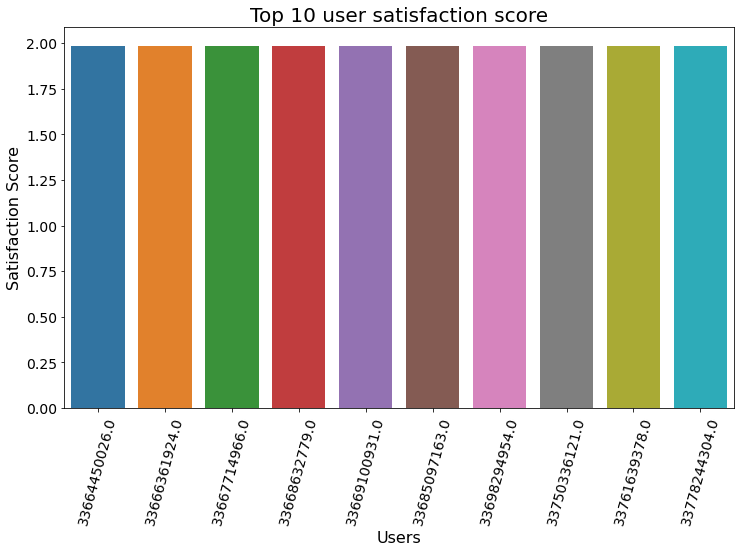

In [49]:
pl.plot_bar(top_10_satisfaction, top_10_satisfaction.index, top_10_satisfaction['satisfaction_score'], "Top 10 user satisfaction score", "Users", "Satisfaction Score")

Build a regression model of your choice to predict the satisfaction score of a customer. 

In [72]:
class Model:
    def __init__(self,X_train,X_test,y_train,y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test


    def model(self):
        self.trained_model = LinearRegression()
        self.trained_model.fit(self.X_train, self.y_train)
        

    def predict(self):
        self.model()
        return self.trained_model.predict(self.X_test)

    def score(self):
        return self.trained_model.score(self.X_test, self.y_test)

    def error_score(self):
        return np.mean((self.trained_model.predict(self.X_test) - self.y_test) ** 2)
    
    def save_model(self, path):
        pickle.dump(self.trained_model, open(path, 'wb'))

Take X as the engagement score, engagement score and y as the satisfaction score.

In [73]:
X = satisfaction_df[['engagement_score', 'experience_score']]
Y = satisfaction_df[['satisfaction_score']]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42) 

In [74]:
model = Model(X_train, X_test, y_train, y_test)

In [75]:
model.predict()

array([[1.05493311],
       [0.48790332],
       [1.06225209],
       ...,
       [0.29570607],
       [1.89817106],
       [0.2429168 ]])

In [76]:
model.score()

1.0

In [77]:
model.error_score()

satisfaction_score    5.537067e-32
dtype: float64

In [78]:
model.save_model("../models/satisfaction_model.pkl")

Run a k-means (k=2) on the engagement & the experience score . 